In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
from itertools import permutations, product
from random import sample, choice, shuffle
from glob import glob
import time
from datetime import timedelta
from tqdm import tqdm


%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import torchvision.models as models
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [19]:
def ContrastiveLoss(y,fx1,fx2):
  m=2

  E=torch.pow((fx1-fx2),2)
  
  mat_max = np.maximum(np.zeros((y.shape[0], 128)), torch.pow((m-E),2).detach().cpu().numpy())

  torch_loss = 0.5*(y.detach().cpu().numpy()*torch.pow(E,2).detach().cpu().numpy().T) + (1-y.detach().cpu().numpy())*mat_max.T

  return torch.tensor(torch.sum(torch.tensor(torch_loss.T)), requires_grad=True)

In [20]:
fake = glob("/content/drive/My Drive/faces/fake/*")
real = glob("/content/drive/My Drive/faces/real/*")

In [21]:
fake_ = [x.split("/")[-1] for x in fake]
real_ = [x.split("/")[-1] for x in real]

fake_ = ["fake_" + x for x in fake_]

In [22]:
start = time.time()

pairs_distinct = list(product(real_,fake_))

pairs_real = list(product(real_,real_))

pairs_fake = list(product(fake_,fake_))

end = time.time()

print(f'Time Taken: {timedelta(seconds=(end - start))}')

Time Taken: 0:00:00.288394


In [23]:
len(pairs_distinct) + len(pairs_fake) + len(pairs_real)

3127921

In [24]:
pairs = pairs_distinct + pairs_real + pairs_fake
pairs = sample(pairs, len(pairs))
pairs = list(set(pairs))

In [25]:
ord('f'), ord('r')

(102, 114)

In [26]:
start = time.time()

label_dict = {}
for idx, pair in enumerate(pairs):
    l1, l2 = pair[0].split("_")[0][0], pair[1].split("_")[0][0]
    
    l_sum = ord(l1) + ord(l2)
    
    if l_sum == 204:
        label = 1 #impostor pair
    elif l_sum == 216:
        label = 0
    elif l_sum == 228:
        label = 1 # real pair
    
    label_dict[idx] = label

end = time.time()

print(f'Time Taken: {timedelta(seconds=(end - start))}')

Time Taken: 0:00:04.225092


In [27]:
class DFDataset(Dataset):
    
    def __init__(self, root_dir, real_dir, fake_dir, pairs, lab_dict, transform=None):
        self.root_dir = root_dir
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        self.pairs = pairs
        self.lab_dict = lab_dict
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        class_labels = []
        
        if pair[0].split("_")[0] == "real":
            img1 = Image.open(f'{self.root_dir}/{self.real_dir}/{pair[0]}')
            class_labels.append(1)
            
        elif pair[0].split("_")[0] == "fake":
            path_ = pair[0].replace('fake_', '')
            img1 = Image.open(f'{self.root_dir}/{self.fake_dir}/{path_}')
            class_labels.append(0)
            
        if pair[1].split("_")[0] == "real":
            img2 = Image.open(f'{self.root_dir}/{self.real_dir}/{pair[1]}')
            class_labels.append(1)
            
        elif pair[1].split("_")[0] == "fake":
            path_ = pair[1].replace('fake_', '')
            img2 = Image.open(f'{self.root_dir}/{self.fake_dir}/{path_}')
            class_labels.append(0)
            
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        
        label = self.lab_dict[idx]
        
        return img1, img2, label, class_labels
        

In [28]:
BATCH_SIZE=64
NUMBER_EPOCHS=1
IMG_SIZE=100

In [29]:
len(pairs)

3127921

In [30]:
a, b, c = np.array_split(pairs, 3)

In [31]:
len(a), len(b), len(c)

(1042641, 1042640, 1042640)

In [32]:
trainset = DFDataset('/content/drive/My Drive/faces', 'real', 'fake', sample(list(a), 1000), label_dict, 
                                                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        batch_size=BATCH_SIZE)


valset = DFDataset('/content/drive/My Drive/faces', 'real', 'fake', sample(list(b), 1000), label_dict, 
                                                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

valloader = DataLoader(valset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        batch_size=BATCH_SIZE)


In [33]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

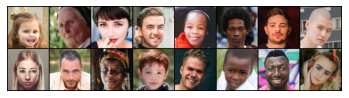

[1 0 0 1 0 1 1 1]


In [34]:
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [47]:
alexnet = models.alexnet()

In [48]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [55]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = models.alexnet(pretrained=True)#resnet50 doesn't work, might because pretrained model recognize all faces as the same.
        # self.cnn1 = nn.Sequential(
        #     nn.ReflectionPad2d(1),
        #     nn.Conv2d(3, BATCH_SIZE, kernel_size=3),
        #     nn.ReLU(inplace=True),
        #     nn.BatchNorm2d(BATCH_SIZE),
        #     nn.Dropout2d(p=.2),
            
        #     nn.ReflectionPad2d(1),
        #     nn.Conv2d(BATCH_SIZE, BATCH_SIZE, kernel_size=3),
        #     nn.ReLU(inplace=True),
        #     nn.BatchNorm2d(BATCH_SIZE),
        #     nn.Dropout2d(p=.2),

        #     nn.ReflectionPad2d(1),
        #     nn.Conv2d(BATCH_SIZE, 32, kernel_size=3),
        #     nn.ReLU(inplace=True),
        #     nn.BatchNorm2d(32),
        #     nn.Dropout2d(p=.2),
        # )
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 128)


    def forward(self, inputs):#did not know how to let two resnet share the same param.
        results = []

        for input in inputs:
            output = self.cnn1(input)
            output = output.view(output.size()[0], -1)
            output = F.relu(self.fc1(output))
            output = F.relu(self.fc2(output))
            output = self.fc3(output)

            results.append(output)

        return results

Epoch： 0  start.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Epoch number 0
 Current loss 11252.480857306471

Epoch number 0
 Current loss 9459.7264129814

Epoch number 0
 Current loss 9891.272865546282

Epoch number 0
 Current loss 12720.511709037784

Epoch number 0
 Current loss 13381.86301159752

Epoch number 0
 Current loss 13496.835363429604

Epoch number 0
 Current loss 12651.453282222363

Epoch number 0
 Current loss 7178.975089429138

Epoch number 0
 Current loss 10464.36288226159

Epoch number 0
 Current loss 10905.85254262365

Epoch number 0
 Current loss 8448.536971164851

Epoch number 0
 Current loss 7561.226625904709

Epoch number 0
 Current loss 8616.648959010934

Epoch number 0
 Current loss 12578.082716819588

Epoch number 0
 Current loss 11692.596321528838

Epoch number 0
 Current loss 6612.997903209548

Accuracy of the network on the 1000 : 0 %


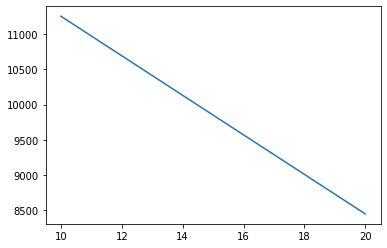

In [56]:
net = SiameseNetwork().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels, _ = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net([img0,img1])
        loss = ContrastiveLoss(labels, outputs[0], outputs[1])
        loss.backward()
        optimizer.step()

        print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
        if i %10 == 0 :#show changes of loss value after each 10 batches
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    # print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
    
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing!!!!
        for data in valloader:
            img0, img1 , labels, _ = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net([img0,img1])
            _, predicted = torch.max(outputs[0].data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the', total_val,': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)

In [37]:
class NeuralNet(nn.Module):
    
    def __init__(self, in_features=4, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features=128,
                             out_features=120)
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84,  
                             out_features=2)
        self.activation = nn.Softmax(dim=1)

        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        return self.activation(X)

In [38]:
net = NeuralNet().cuda()
net2 = SiameseNetwork().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

outputs = None
lab = None

for i, data in enumerate(trainloader,0):
     img0, img1 , labels, class_labels = data
     img0, img1 , labels = img0.cuda(), img1.cuda(), labels.cuda()
     optimizer.zero_grad()
    #  print(img1.shape)
     outputs = net2([img0, img1])
     print(outputs[0].shape)
     out2 = net(outputs[0])
     print(out2.shape)
     print(out2[0])
     torch.max(out2.data, 1)
     loss = criterion(out2, class_labels[0].cuda())

    #  lab = labels

    #  loss = ContrastiveLoss(labels, outputs[0], outputs[1])

     loss.backward()

     break

torch.Size([64, 128])
torch.Size([64, 2])
tensor([0.5166, 0.4834], device='cuda:0', grad_fn=<SelectBackward0>)


Epoch： 0  start.
Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931483745574951

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.693149209022522

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931524276733398

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931478977203369

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931474804878235

Accuracy of the network on the 1000 : 32 %


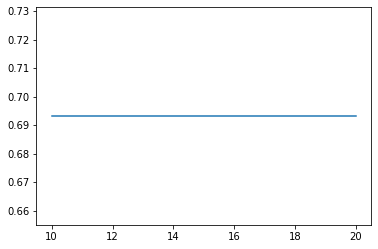

In [39]:
net = SiameseNetwork().cuda()
net2 = NeuralNet().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels, class_labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net([img0,img1])
        out2 = net2(outputs[0])
        loss = criterion(out2, class_labels[0].cuda())

        loss.backward()
        optimizer.step()

        print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
        if i %10 == 0 :#show changes of loss value after each 10 batches
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    # print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
    
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing!!!!
        for data in valloader:
            img0, img1 , labels, class_labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net([img0,img1])
            out = net2(outputs[0])
            _, predicted = torch.max(out.data, 1)
            total_val += class_labels[0].cuda().size(0)
            correct_val += (predicted == class_labels[0].cuda()).sum().item()
            
    print('Accuracy of the network on the', total_val,': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)

In [40]:
net.eval()
net2.eval()
test_transforms = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
                                                                      
def predict_image(image):
    img=Image.open(image)
    image_tensor = test_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.cuda()
    out1=net([input])
    output = net2(out1[0])
    print(output.data.cpu().numpy())
    index = output.data.cpu().numpy().argmax()
    return index

In [44]:
predict_image("/content/drive/MyDrive/faces/real/real_01081.jpg")

[[0.5 0.5]]


0

In [42]:
torch.save(net.state_dict(),"net.pth")
torch.save(net2.state_dict(),"net2.pth")

In [43]:
# net=torch.load("net")
# net2=torch.load("net2")